In [9]:
# Import necessary libraries
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Load the .fits file
file_path = "sat_interest_25/ETH_20250108_004500_01.fit"  # Replace with your actual file path
hdul = fits.open(file_path)

# Display the header information (optional)
#print("Header information:")
#print(hdul[0].header)

# Access the data (assuming it's a 2D array with shape [frequency, time])
data = hdul[0].data
print(data.shape)

# Extract frequency and time from header (if provided)
# You may need to adjust these keys based on your file
freq_axis = np.arange(data.shape[0])  # Dummy frequency axis if not provided
freq_axis = hdul[1].data[0][1]
time_axis = np.arange(data.shape[1])  # Dummy time axis if not provided

# Close the file
hdul.close()

# Choose a specific frequency index (modify as needed)
frequency_index = 79  # Example: choose the 50th frequency; adjust as per your data
chosen_frequency = freq_axis[frequency_index]  # Get the actual frequency value if freq_axis is defined



(200, 3600)


Fitted Gaussian Parameters:
Amplitude: 15.290598489370963
Center (x0): 2562.9962711289654
Width (sigma): 99.64598073583444
Baseline (y0): 85.57549559519026


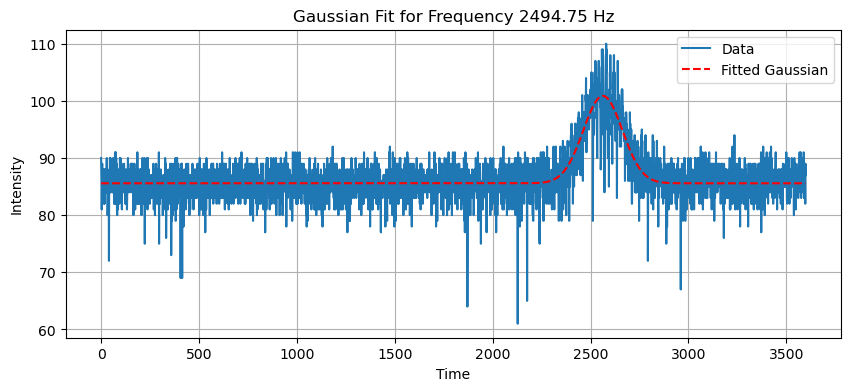

Peak Time Period: 2363.70 to 2762.29


In [10]:
from scipy.optimize import curve_fit

intensity = data[frequency_index, :]

# Define a Gaussian function
def gaussian(x, a, x0, sigma, y0):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + y0

# Estimate initial parameters for the Gaussian
a_initial = np.max(intensity) - np.min(intensity)  # Amplitude guess
x0_initial = time_axis[np.argmax(intensity)]  # Peak position guess
sigma_initial = np.std(time_axis) / 10  # Width guess
y0_initial = np.min(intensity)  # Baseline guess
initial_guess = [a_initial, x0_initial, sigma_initial, y0_initial]

# Fit the Gaussian
params, covariance = curve_fit(gaussian, time_axis, intensity, p0=initial_guess)

# Extract fitted parameters
a_fit, x0_fit, sigma_fit, y0_fit = params
print(f"Fitted Gaussian Parameters:\n"
      f"Amplitude: {a_fit}\n"
      f"Center (x0): {x0_fit}\n"
      f"Width (sigma): {sigma_fit}\n"
      f"Baseline (y0): {y0_fit}")

# Plot the fitted Gaussian over the data
plt.figure(figsize=(10, 4))
plt.plot(time_axis, intensity, label='Data')
plt.plot(time_axis, gaussian(time_axis, *params), label='Fitted Gaussian', linestyle='--', color='red')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title(f'Gaussian Fit for Frequency {chosen_frequency} Hz')
plt.legend()
plt.grid(True)
plt.show()

# Return the starting values of the Gaussian
start_time = x0_fit - 2 * sigma_fit
end_time = x0_fit + 2 * sigma_fit
print(f"Peak Time Period: {start_time:.2f} to {end_time:.2f}")
dT = 2*np.sqrt(2*np.log(2))*sigma_fit

In [11]:
import sympy as sp

# Define the symbols
r= sp.symbols('r')

# Constants (with units converted where necessary)
R = 6371 * 1000  # Radius of the Earth in meters
G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
M = 5.972e24  # Mass of the Earth in kg
a = 14 * 0.01745329 # Beam angle in radians
t = dT

# Define the equation
equation = r**3 + R*r**2 - (G * M * dT**2) / a**2

# Solve the equation for r
solutions = sp.solve(equation, r)

# Display the solutions
for i, sol in enumerate(solutions):
    print(f"Solution {i + 1}: {sol}")

Solution 1: 5552339.10958999
Solution 2: -5961669.554795 - 5537230.18977095*I
Solution 3: -5961669.554795 + 5537230.18977095*I


In [12]:
import sympy as sp

# Define the symbols
r= sp.symbols('r')

# Constants (with units converted where necessary)
R = 6371 * 1000  # Radius of the Earth in meters
G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
M = 5.972e24  # Mass of the Earth in kg
a = 14 * 0.01745329 # Beam angle in radians
t = dT

# Define the equation
equation = r**3 + R*r**2 - (G * M ) / omega**2

# Solve the equation for r
solutions = sp.solve(equation, r)

# Display the solutions
for i, sol in enumerate(solutions):
    print(f"Solution {i + 1}: {sol}")


Solution 1: -6370999.99799456 + 0.e-20*I
Solution 2: -113.03500278745 + 0.e-17*I
Solution 3: 113.032997343222 + 0.e-17*I


List of Satellite with respective height and time of culmination pass

In [13]:
from skyfield.api import Topos, load, EarthSatellite
from datetime import datetime
import requests

# Function to download TLE data from CelesTrak
def download_tle():
    url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=tle'
    response = requests.get(url)
    response.raise_for_status()  # Check if the request was successful
    tle_lines = response.text.strip().splitlines()
    return tle_lines

# Load satellites using EarthSatellite class
def load_satellites(tle_lines):
    satellites = []
    for i in range(0, len(tle_lines), 3):
        name = tle_lines[i].strip()
        if "STARLINK" not in name.upper():  # Exclude Starlink satellites
            line1 = tle_lines[i + 1].strip()
            line2 = tle_lines[i + 2].strip()
            satellite = EarthSatellite(line1, line2, name, load.timescale())
            satellites.append(satellite)
    return satellites

# Function to predict satellite culmination passes for a given location and time range
def predict_passes(satellites, location, start_time, end_time):
    ts = load.timescale()
    observer = Topos(latitude_degrees=location[0], longitude_degrees=location[1])

    print(f"Predicting satellite culminations for location: {location}")
    for satellite in satellites:
        t, events = satellite.find_events(observer, start_time, end_time, altitude_degrees=30.0)
        for ti, event in zip(t, events):
            if event == 1:  # 1 corresponds to 'culminate'
                # Calculate satellite altitude during culmination
                difference = satellite - observer
                topocentric = difference.at(ti)
                altitude = topocentric.distance().km  # Altitude in kilometers
                print(f"{satellite.name} culminate at {ti.utc_strftime('%Y-%m-%d %H:%M:%S')} UTC, altitude: {altitude:.2f} km")

# Main function
if __name__ == "__main__":
    # Download and load TLE data
    tle_lines = download_tle()
    satellites = load_satellites(tle_lines)

    # Set location for Zurich, Switzerland (latitude, longitude)
    location = (47.3769, 8.5417)

    # Set prediction time range (8 Jan 2025, 01:00 UTC to 8 Jan 2025, 02:00 UTC)
    ts = load.timescale()
    start_time = ts.utc(2025, 1, 8, 1, 0, 0)  # 8 Jan 2025, 01:00 UTC
    end_time = ts.utc(2025, 1, 8, 2, 0, 0)    # 8 Jan 2025, 02:00 UTC

    # Predict satellite culmination passes
    predict_passes(satellites, location, start_time, end_time)


Predicting satellite culminations for location: (47.3769, 8.5417)
CALSPHERE 4A culminate at 2025-01-08 01:48:36 UTC, altitude: 1767.70 km
STARLETTE culminate at 2025-01-08 01:11:51 UTC, altitude: 822.04 km
ORBCOMM FM04 culminate at 2025-01-08 01:46:56 UTC, altitude: 911.08 km
ISS (ZARYA) culminate at 2025-01-08 01:11:29 UTC, altitude: 464.70 km
MAROC-TUBSAT culminate at 2025-01-08 01:52:32 UTC, altitude: 1561.12 km
COSMOS 2390 culminate at 2025-01-08 01:48:13 UTC, altitude: 2155.51 km
COSMOS 2391 culminate at 2025-01-08 01:36:11 UTC, altitude: 2168.98 km
SCISAT 1 culminate at 2025-01-08 01:44:54 UTC, altitude: 938.32 km
LARETS culminate at 2025-01-08 01:55:29 UTC, altitude: 714.70 km
NAVSTAR 54 (USA 177) culminate at 2025-01-08 01:33:52 UTC, altitude: 22038.01 km
AURA culminate at 2025-01-08 01:56:43 UTC, altitude: 708.41 km
BEIJING 1 culminate at 2025-01-08 01:28:20 UTC, altitude: 1146.77 km
SAUDISAT 3 culminate at 2025-01-08 01:45:17 UTC, altitude: 668.55 km
GLOBALSTAR M072 culminate